In [ ]:
import datasets
from datasets import load_dataset, load_from_disk, concatenate_datasets
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
import glob
from tqdm.auto import tqdm
import transformers
import os

In [3]:
tokenizer_path = "../tokenizer/SlimPajama/Jan22_15000"
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(tokenizer_path)

print(f"The vocab size is {tokenizer.vocab_size}")

The vocab size is 15000


## Analysis of the filtered dataset

In [4]:
# load the AOChildes vocabulary
vocab = pd.read_csv("../data/AOChildes/AOChildes_word_frequency.csv", index_col=0)
vocab = set(w.lower() for w in vocab["word"] if isinstance(w, str))

In [5]:
vocab_dataset = datasets.Dataset.from_dict({"text": list(vocab)})

In [4]:
def tokenize_and_count(example):
    tokenized_data = tokenizer(example["text"], padding=False)
    return {"length": len(tokenized_data["input_ids"]),
            "tokenized_text": tokenized_data["input_ids"]}

In [7]:
vocab_dataset_tokenized = vocab_dataset.map(tokenize_and_count, batch_size=1000)

Map: 100%|██████████| 21036/21036 [00:01<00:00, 14863.63 examples/s]


In [8]:
avg_token_length_vocab = sum(vocab_dataset_tokenized["length"]) / vocab_dataset_tokenized.num_rows

In [9]:
avg_token_length_vocab

2.0564746149458073

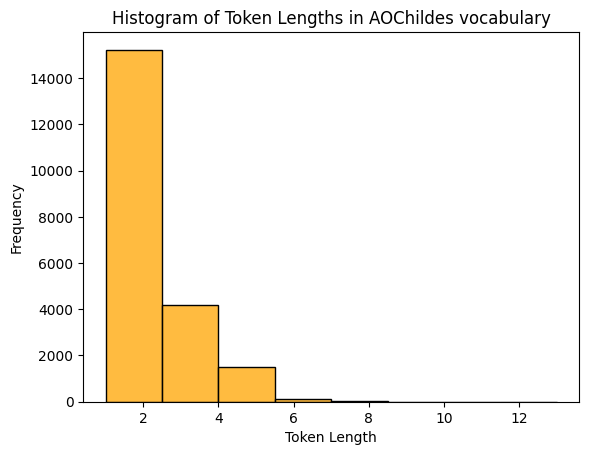

In [10]:
# plot histogram of token lengths
import seaborn as sns
import matplotlib.pyplot as plt

# Sample token lengths
token_lengths = vocab_dataset_tokenized["length"]

# Plot the histogram
sns.histplot(token_lengths, bins=8, kde=False, color='orange')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Histogram of Token Lengths in AOChildes vocabulary')
plt.show()

# Most of  the words in AOChildes are 2-4 tokens long, with a long tail of longer words

In [ ]:
# chunk 1 get the number of filtered number of tokens
chunk = 'chunk7'
chunk1_path = f"../data/pretraining_data/slimpajama/filtered/debug_Jan4/{chunk}/"
print(f"Chunk path is {chunk1_path}")
chunk_subsets =  ['c4', 'github', 'common_crawl', 'stack_exchange', 'wikipedia', 'arxiv', 'books']
ids = [0, 1, 2, 3, 4, 5, 6]
# ids = [6]
dataset_splits = []
chunk_id = 1
for id in ids:
    print(f"Split is {chunk_subsets[id]} ")
    dataset_files = glob.glob(f"{chunk1_path}/*idx_{id}*", recursive=True)

    dataset = [load_from_disk(dataset_file) for dataset_file in dataset_files]
    combined_dataset = concatenate_datasets(dataset)
    combined_dataset = combined_dataset.filter(lambda x: x['word_count'] > 0)
    combined_dataset_tokenized = combined_dataset.map(tokenize_and_count, batch_size=1000, num_proc=8)
    num_tokens = sum(combined_dataset_tokenized["length"])
    split = chunk_subsets[id]
    print(f"Number of tokens from split {split}: {num_tokens}")
    dataset_splits.append(combined_dataset)

# chunk1_dataset = concatenate_datasets(dataset_splits)

In [5]:
ds = load_from_disk("../data/pretraining_data/slimpajama/unfiltered/debug_oct11_context128_vocab_21k")

In [ ]:
## unfiltered data
chunk1_path = f"../data/pretraining_data/slimpajama/unfiltered/debug_oct11_context128_vocab_21k/chunk1"
print(f"Chunk path is {chunk1_path}")


# ids = [6]
dataset_splits = []
chunk_id = 1
for id in ids:
    print(f"Split is {chunk_subsets[id]} ")
    dataset_files = glob.glob(f"{chunk1_path}/*idx_{id}*", recursive=True)

    dataset = [load_from_disk(dataset_file) for dataset_file in dataset_files]
    combined_dataset = concatenate_datasets(dataset)
    combined_dataset = combined_dataset.filter(lambda x: x['word_count'] > 0)
    combined_dataset_tokenized = combined_dataset.map(tokenize_and_count, batch_size=1000, num_proc=8)
    num_tokens = sum(combined_dataset_tokenized["length"])
    split = chunk_subsets[id]
    print(f"Number of tokens from split {split}: {num_tokens}")
    dataset_splits.append(combined_dataset)

chunk1_dataset = concatenate_datasets(dataset_splits)

In [21]:
# create the dataset by concatenating the splits and the chunks

def createChunkDatasets(chunk_id):
    base_path = "../data/pretraining_data/slimpajama/filtered/debug_Jan4/"
    chunk_path = os.path.join(base_path, f"chunk{chunk_id}")
    print(f"Chunk path is {chunk_path}")

    # chunk_path = "../pretraining_data/pretrain/slimpajama/debug_Sep20/chunk2/"
    #  collect all files in the chunk
    dataset_files = glob.glob(f"{chunk_path}/**/", recursive=True)
    print("The length of the dataset files is ", len(dataset_files))

    datasets = [load_from_disk(dataset_file) for dataset_file in tqdm(dataset_files) if 'file_example' in dataset_file]
    print("Datasets loaded from disk")

    combined_dataset = concatenate_datasets(datasets)
    print("Datasets concatenated")

    minigpt_dataset_chunk2 = combined_dataset.filter(lambda x: x['word_count'] > 0)
    print("Datasets filtered")

    path_to_save = os.path.join(base_path, f"minigpt_chunk{chunk_id}_dataset")
    # # path_to_save = f'../pretraining_data/pretrain/slimpajama/debug_Sep20/minigpt_dataset_2/'
    minigpt_dataset_chunk2.save_to_disk(path_to_save)
    print("Datasets saved")


In [27]:
# ignore chunk 8 for now
createChunkDatasets(8)
# figure out what to do with 8
# for i in range(9, 11):
    # createChunkDatasets(i)

Chunk path is ../data/pretraining_data/slimpajama/filtered/debug_Jan4/chunk8
The length of the dataset files is  5117


100%|██████████| 5117/5117 [00:10<00:00, 477.72it/s]


Datasets loaded from disk
Datasets concatenated
Datasets filtered


Saving the dataset (2/2 shards): 100%|██████████| 3689664/3689664 [00:18<00:00, 194930.89 examples/s]


Datasets saved


In [3]:
# concatenate all the individual chunk datasets
base_path = "../data/pretraining_data/slimpajama/filtered/debug_Jan4/"
chunk_datasets = [load_from_disk(os.path.join(base_path, f"minigpt_chunk{i}_dataset")) for i in range(1, 11)]

minigpt_ds = concatenate_datasets(chunk_datasets)
path_to_save = os.path.join(base_path, f"minigpt_dataset")
minigpt_ds.save_to_disk(path_to_save)

Saving the dataset (197/197 shards): 100%|██████████| 142498558/142498558 [08:28<00:00, 280365.66 examples/s]


In [20]:
ds = load_from_disk(path_to_save)

In [22]:
sum(ds[:]['word_count'])

## Analysis of the unfiltered dataset (after collecting the first 2B tokens)

In [3]:
chunk_path = "../pretraining_data/pretrain/slimpajama/unfiltered/debug_oct11/chunk1"
dataset_files = glob.glob(f"{chunk_path}/**/", recursive=True)
print("The length of the dataset files is ", len(dataset_files))
datasets = [load_from_disk(dataset_file) for dataset_file in tqdm(dataset_files) if 'file_example' in dataset_file]
print("Datasets loaded from disk")
slimpajama_unfiltered_dataset = concatenate_datasets(datasets)
print("Datasets concatenated")
path_to_save = f'../pretraining_data/pretrain/slimpajama/unfiltered/debug_oct11/'
slimpajama_unfiltered_dataset.save_to_disk(path_to_save)
print("Datasets saved")

The length of the dataset files is  182


100%|██████████| 182/182 [00:02<00:00, 78.02it/s] 


Datasets loaded from disk
Datasets concatenated


Saving the dataset (16/16 shards): 100%|██████████| 1806380/1806380 [00:24<00:00, 75076.62 examples/s] 

Datasets saved


In [11]:
slim_ds = load_from_disk("../data/pretraining_data/slimpajama/unfiltered/debug_oct11_context128_vocab_21k/")

In [12]:
slim_ds

Dataset({
    features: ['text', 'src', 'num_tokens'],
    num_rows: 1806380
})

In [13]:
slim_ds[1806000]["num_tokens"]

821

In [20]:
# count the split of data
from collections import Counter

splits = Counter(slim_ds['src'])

In [28]:
c4 = slim_ds.filter(lambda x: x['src'] == 'RedPajamaC4')


c4 tokens [630, 578, 282, 392, 301, 243, 396, 313, 61, 198, 992, 1047, 314, 154, 395, 57, 223, 513, 58, 405, 297, 571, 441, 64, 154, 477, 76, 815, 589, 78, 1000, 280, 323, 1201, 200, 119, 2556, 1743, 345, 121, 192, 248, 436, 86, 746, 267, 342, 563, 435, 801, 384, 164, 848, 713, 81, 1093, 522, 458, 268, 153, 1063, 749, 64, 183, 77, 143, 408, 664, 1044, 117, 198, 482, 2990, 377, 973, 279, 239, 574, 119, 3181, 226, 176, 111, 366, 1030, 885, 1462, 585, 210, 292, 60, 121, 137, 119, 96, 500, 53, 486, 292, 83, 720, 189, 1006, 297, 660, 111, 221, 702, 704, 90, 130, 447, 436, 295, 1147, 770, 384, 1114, 1250, 342, 530, 275, 90, 107, 2313, 86, 449, 624, 687, 138, 108, 58, 429, 504, 182, 1328, 2173, 194, 104, 263, 333, 69, 81, 275, 227, 618, 889, 373, 387, 158, 2374, 266, 708, 448, 61, 91, 286, 113, 629, 211, 85, 382, 1439, 583, 213, 730, 103, 498, 741, 472, 217, 850, 390, 812, 131, 99, 102, 144, 3001, 145, 254, 932, 43, 846, 402, 234, 976, 1134, 131, 348, 790, 226, 900, 1025, 160, 134, 387, 1476,

In [30]:
print(f"c4 tokens {sum(c4['num_tokens'])}")

c4 tokens 560175419


In [17]:
import pandas as pd

cc = slim_ds.filter(lambda x: x['src'] == 'RedPajamaCommonCrawl')
cc_tokens = sum(cc['num_tokens'])
print(f"cc tokens {sum(cc['num_tokens'])}")

se = slim_ds.filter(lambda x: x['src'] == 'RedPajamaStackExchange')
se_tokens = sum(se['num_tokens'])
print(f"se tokens {sum(se['num_tokens'])}")

wiki = slim_ds.filter(lambda x: x['src'] == 'RedPajamaWikipedia')
wiki_tokens = sum(wiki['num_tokens'])
print(f"wiki tokens {sum(wiki['num_tokens'])}")

github = slim_ds.filter(lambda x: x['src'] == 'RedPajamaGithub')
github_tokens = sum(github['num_tokens'])
print(f"github tokens {sum(github['num_tokens'])}")

ar = slim_ds.filter(lambda x: x['src'] == 'RedPajamaArXiv')
arxiv_tokens = sum(ar['num_tokens'])
print(f"ar tokens {sum(ar['num_tokens'])}")

book= slim_ds.filter(lambda x: x['src'] == 'RedPajamaBook')
book_tokens = sum(book['num_tokens'])
print(f"book tokens {sum(book['num_tokens'])}")

c4= slim_ds.filter(lambda x: x['src'] == 'RedPajamaC4')
c4_tokens = sum(c4['num_tokens'])
print(f"c4 tokens {sum(c4['num_tokens'])}")

total_tokens = sum(slim_ds['num_tokens'])
data = {
    'Split': ['C4', 'GitHub', 'Commoncrawl', 'StackExchange', 'Wikipedia', 'ArXiv', 'Books', 'Total'],
    'Number of Tokens': [c4_tokens, github_tokens, cc_tokens, se_tokens, wiki_tokens, arxiv_tokens, book_tokens, total_tokens],
    'Percentage of Tokens': [c4_tokens/total_tokens, github_tokens/total_tokens, cc_tokens/total_tokens, se_tokens/total_tokens, wiki_tokens/total_tokens, arxiv_tokens/total_tokens, book_tokens/total_tokens, 1]
}
df = pd.DataFrame(data)
print(df)

cc tokens 1124513188
se tokens 67161900
wiki tokens 92806650
github tokens 103595471
ar tokens 98550598
book tokens 85835756


Filter: 100%|██████████| 1806380/1806380 [00:18<00:00, 97017.67 examples/s] 


book tokens 560175419
           Split  Number of Tokens  Percentage of Tokens
0             C4         560175419              0.262668
1         GitHub         103595471              0.048576
2    Commoncrawl        1124513188              0.527287
3  StackExchange          67161900              0.031492
4      Wikipedia          92806650              0.043517
5          ArXiv          98550598              0.046211
6          Books          85835756              0.040249
7          Total        2132638982              1.000000


In [32]:
sum(slim_ds['num_tokens'])

2132638982

In [21]:
splits

Counter({'RedPajamaC4': 993378,
         'RedPajamaCommonCrawl': 569582,
         'RedPajamaStackExchange': 90924,
         'RedPajamaWikipedia': 82216,
         'RedPajamaGithub': 65003,
         'RedPajamaArXiv': 4665,
         'RedPajamaBook': 612})